In [1]:
import os
import sys
import torch
from torch import nn
import torch.nn.functional as F
import subprocess
import pytorch3d
from pytorch3d.loss import (
    chamfer_distance,
    mesh_edge_loss,
    mesh_laplacian_smoothing,
    mesh_normal_consistency,
)
from pytorch3d.ops import iterative_closest_point as icp
from pytorch3d.ops import sample_farthest_points as sfp
from pytorch3d.transforms import quaternion_to_matrix
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib as mpl
import tqdm
import imageio
import io
from PIL import Image
import random
from models.mlp import MLP
from models.utils import PoseEnc
from pointnet2_utils import (
    PointNetSetAbstractionMsg,
    PointNetSetAbstraction,
    PointNetFeaturePropagation,
)
from sklearn.neighbors import NearestNeighbors

In [2]:
def estimate_surface_normals(point_cloud, num_nn):
    """
    Estimate the surface normals for a point cloud.

    Args:
    - point_cloud (torch.Tensor): The point cloud (N, 3).
    - num_nn (int): The number of nearest neighbors to use for normal estimation.

    Returns:
    - normals (torch.Tensor): The estimated surface normals (N, 3).
    """
    num_pts = point_cloud.size(0)

    # Convert point cloud to numpy for NearestNeighbors
    point_cloud_np = point_cloud.cpu().numpy()

    # Find the nearest neighbors
    nbrs = NearestNeighbors(n_neighbors=num_nn + 1, algorithm="auto").fit(
        point_cloud_np
    )
    distances, indices = nbrs.kneighbors(point_cloud_np)

    # Initialize tensor for normals
    normals = torch.zeros((num_pts, 3), device=point_cloud.device)

    for pt_idx in range(num_pts):
        # Extract the nearest neighbors
        neighbors = point_cloud[indices[pt_idx, 1:], :]

        # Center the neighbors by subtracting the mean
        neighbors_centered = neighbors - neighbors.mean(dim=0, keepdim=True)

        # Compute the covariance matrix
        covariance_matrix = neighbors_centered.t().mm(neighbors_centered) / (num_nn - 1)

        # Perform eigen decomposition
        eigenvalues, eigenvectors = torch.eig(covariance_matrix, eigenvectors=True)

        # The eigenvector corresponding to the smallest eigenvalue is the normal
        normal = eigenvectors[:, eigenvalues[:, 0].argmin()]

        # Store the normal
        normals[pt_idx, :] = normal

    return normals

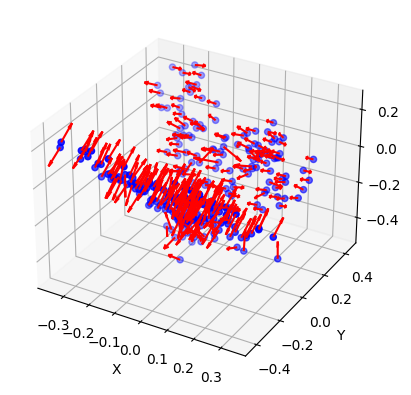

In [4]:
src_pc_path = "/NAS/spa176/papr-retarget/point_clouds/butterfly/points_0.npy"
src_pc = np.load(src_pc_path)
src_pc = src_pc / 10.0
# calculate normals
src_pc = torch.tensor(src_pc)
src_normals = estimate_surface_normals(src_pc, 100)
src_normals = src_normals / torch.norm(src_normals, dim=1, keepdim=True)
src_normals = src_normals.numpy()
# subsample the point cloud and normals
src_pc = src_pc.numpy()
src_pc = src_pc[::100]
src_normals = src_normals[::100]
# plot the surface normals on the point cloud
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.scatter(src_pc[:, 0], src_pc[:, 1], src_pc[:, 2], c="b", marker="o")
ax.quiver(
    src_pc[:, 0],
    src_pc[:, 1],
    src_pc[:, 2],
    src_normals[:, 0],
    src_normals[:, 1],
    src_normals[:, 2],
    length=0.1,
    color="r",
)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.show()


/tmp/ipykernel_2684565/15408349.py:37: UserWarning: torch.eig is deprecated in favor of torch.linalg.eig and will be removed in a future PyTorch release.
torch.linalg.eig returns complex tensors of dtype cfloat or cdouble rather than real tensors mimicking complex tensors.
L, _ = torch.eig(A)
should be replaced with
L_complex = torch.linalg.eigvals(A)
and
L, V = torch.eig(A, eigenvectors=True)
should be replaced with
L_complex, V_complex = torch.linalg.eig(A) (Triggered internally at  /opt/conda/conda-bld/pytorch_1656352465323/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:3415.)
  eigenvalues, eigenvectors = torch.eig(covariance_matrix, eigenvectors=True)


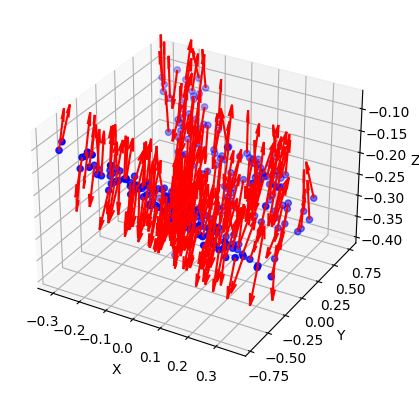

In [3]:
src_pc_path = "/NAS/spa176/papr-retarget/point_clouds/butterfly/points_30000.npy"
src_pc = np.load(src_pc_path)
src_pc = src_pc / 10.0
# calculate normals
src_pc = torch.tensor(src_pc)
src_normals = estimate_surface_normals(src_pc, 100)
src_normals = src_normals / torch.norm(src_normals, dim=1, keepdim=True)
src_normals = src_normals.numpy()
# subsample the point cloud and normals
src_pc = src_pc.numpy()
src_pc = src_pc[::100]
src_normals = src_normals[::100]
# plot the surface normals on the point cloud
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.scatter(src_pc[:, 0], src_pc[:, 1], src_pc[:, 2], c="b", marker="o")
ax.quiver(
    src_pc[:, 0],
    src_pc[:, 1],
    src_pc[:, 2],
    src_normals[:, 0],
    src_normals[:, 1],
    src_normals[:, 2],
    length=0.1,
    color="r",
)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.show()

In [5]:
class DeformNet(nn.Module):
    def __init__(self, in_dim, out_dim=3, hidden_dim=256, num_layers=3, L=0):
        super().__init__()

        self.pose_enc = PoseEnc()
        self.L = L
        in_dim = 3 + 3 * 2 * L
        self.mlp = MLP(
            in_dim,
            num_layers,
            hidden_dim,
            out_dim,
            use_wn=False,
            act_type="relu",
            last_act_type="none",
        )

    def forward(self, x):
        x = self.pose_enc(x, self.L)
        return self.mlp(x)



In [6]:
device = torch.device("cuda:0")
# tgt_pc_path = "/NAS/spa176/papr-retarget/point_clouds/hummingbird/points_0.npy"
# tgt_pc = np.load(tgt_pc_path)
# src_pc = torch.tensor(src_pc).float()
# tgt_pc = torch.tensor(tgt_pc).float()
# scale = 10.0
num_layers = 3
hidden_dim = 256
L = 0

log_dir = "fit_pointcloud_logs"
exp_dir = f"learn_mlp_icp_shift_pe{L}"
# exp_dir = f'learn_mlp_icp_shift_pe{L}_pointnet'
log_dir = os.path.join(log_dir, exp_dir)

# tgt_pc = tgt_pc / scale

# converged, rmse, Xt, RTs, t_history = icp(tgt_pc.unsqueeze(0), src_pc.unsqueeze(0))
# print(f"ICP converged: {converged}, RMSE: {rmse}, Iterations: {len(t_history)}, Final Transformation: {Xt.shape}")
# tgt_pc = Xt.squeeze(0)

src_pc_dir = "/NAS/yza629/codes/papr-retarget/point_clouds/butterfly"
start = 0
end = 30001
interval = 1000
src_pcs = []
deformed_pcs = []
for idx in tqdm.tqdm(range(start, end, interval)):
    src_pc_path = os.path.join(src_pc_dir, f"points_{idx}.npy")
    src_pc = np.load(src_pc_path)

    # src_pc = torch.tensor(src_pc).float().to(device)
    src_pc = torch.tensor(src_pc).float()

    scale = 10.0
    src_pc = src_pc / scale

    src_pcs.append(src_pc)
src_pcs = torch.stack(src_pcs, dim=0)

reg_net = DeformNet(3, 3, hidden_dim=hidden_dim, num_layers=num_layers, L=L).to(device)
reg_net.load_state_dict(torch.load(os.path.join(log_dir, "deform_net.pth")))

with torch.no_grad():
    init_displacement = reg_net(src_pcs[0:1].to(device))
    deformed_src_pc = src_pcs[0] + init_displacement[0].detach().cpu().clone()

del reg_net

100%|██████████| 31/31 [00:01<00:00, 19.91it/s]


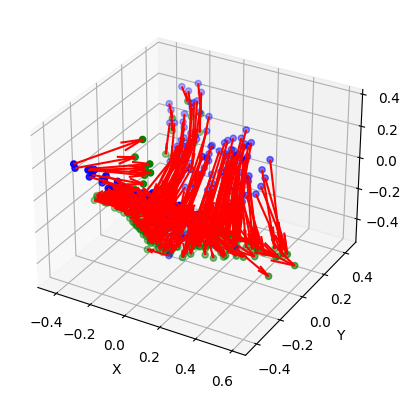

In [12]:
# subsample init_displacement and plot the deformed point cloud
init_displacement_cpu = init_displacement.cpu().numpy()[0]
init_displacement_cpu = init_displacement_cpu[::100]
src_pc = src_pcs[0].cpu().numpy()[::100]
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
# plot the src_pc and draw the displacement vectors init_displacement
# plot the deformed point cloud and draw the displacement vectors init_displacement in between
deformed_src_pc_cpu = deformed_src_pc.cpu().numpy()[::100]
ax.scatter(src_pc[:, 0], src_pc[:, 1], src_pc[:, 2], c="b", marker="o")
ax.scatter(deformed_src_pc_cpu[:, 0], deformed_src_pc_cpu[:, 1], deformed_src_pc_cpu[:, 2], c="g", marker="o")
ax.quiver(
    src_pc[:, 0],
    src_pc[:, 1],
    src_pc[:, 2],
    init_displacement_cpu[:, 0],
    init_displacement_cpu[:, 1],
    init_displacement_cpu[:, 2],
    # length=0.2,
    color="r",
)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.show()